# 3D Model Generation


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import camutils
import meshutils
import visutils
import pickle
import os
import glob
import cv2
import matplotlib.tri as mtri
from collections import defaultdict
from scipy.spatial import Delaunay

%matplotlib inline

# Modified reconstruct Function for Handling Color

In [2]:
def reconstruct(scanFolder,mask_thres,decode_thres,camL,camR):
    """
    Reconstruction based on triangulating matched pairs of points
    between to view which have been encoded with a 20bit gray code
    for colored images.

    Parameters
    ----------
    scanFolder : str
      folder for where the images are stored
      
    mask_thres : int
      object mask threshold

    decode_thres : float
      decodability threshold

    camL,camR : Camera
      camera parameters
      
    Returns
    -------
    pts2L,pts2R : 2D numpy.array (dtype=float)

    pts3 : 2D numpy.array (dtype=float)
    
    ptsColor : 2D numpy.array (3xN array where N = number of points)

    """
    # Image prefixes 
    frameprefixL = scanFolder + "/frame_C0_"
    colorprefixL = scanFolder + "/color_C0_"
    frameprefixR = scanFolder + "/frame_C1_"
    colorprefixR = scanFolder + "/color_C1_"

    # Decode coordinates for both views
    CLh,maskLh = camutils.decode(frameprefixL,0,decode_thres)
    CLv,maskLv = camutils.decode(frameprefixL,20,decode_thres)
    CRh,maskRh = camutils.decode(frameprefixR,0,decode_thres)
    CRv,maskRv = camutils.decode(frameprefixR,20,decode_thres)
    
    # Grab color from background and foreground
    bgL = plt.imread(colorprefixL + "00.png")
    fgL = plt.imread(colorprefixL + "01.png")
    bgR = plt.imread(colorprefixR + "00.png")
    fgR = plt.imread(colorprefixR + "01.png")
    
    # Save color for later
    fgL_orig = fgL
    
    # Convert to float and grayscale
    img_shape = bgL.shape
    
    if (bgL.dtype == np.uint8):
        bgL = bgL.astype(float) / 256
        fgL = fgL.astype(float) / 256
        bgR = bgR.astype(float) / 256
        fgR = fgR.astype(float) / 256

    if len(img_shape) == 3:
        # Drop alpha
        if img_shape[-1] == 4:
            bgL = bgL[:,:,:-1]
            fgL = fgL[:,:,:-1]
            bgR = bgL[:,:,:-1]
            fgR = fgL[:,:,:-1]
        bgL = np.average(bgL, axis=2)
        fgL = np.average(fgL, axis=2)
        bgR = np.average(bgR, axis=2)
        fgR = np.average(fgR, axis=2)
    
    # Construct object mask
    objMaskL = np.absolute(fgL - bgL) > mask_thres
    objMaskR = np.absolute(fgR - bgR) > mask_thres
    
    # Construct code and mask for views
    CL = CLh + 1024*CLv
    maskL = maskLh*maskLv*objMaskL
    CR = CRh + 1024*CRv
    maskR = maskRh*maskRv*objMaskR
    
    # Find intersections
    h, w = CR.shape

    subR = np.nonzero(maskR.flatten())
    subL = np.nonzero(maskL.flatten())

    CRgood = CR.flatten()[subR]
    CLgood = CL.flatten()[subL]

    _,submatchR,submatchL = np.intersect1d(CRgood,CLgood,return_indices=True)

    matchR = subR[0][submatchR]
    matchL = subL[0][submatchL]

    xx,yy = np.meshgrid(range(w),range(h))
    xx = np.reshape(xx,(-1,1))
    yy = np.reshape(yy,(-1,1))

    pts2R = np.concatenate((xx[matchR].T,yy[matchR].T),axis=0)
    pts2L = np.concatenate((xx[matchL].T,yy[matchL].T),axis=0)

    pts3 = camutils.triangulate(pts2L,camL,pts2R,camR)
    ptsColor = fgL_orig[pts2L[1,:], pts2L[0,:], :].T

    return pts2L,pts2R,pts3,ptsColor

# Mesh Smoothing Function

In [3]:
def build_neighbor_dict(tri):
    # Auxiliary function to build dict of points and corresponding neighbors
    result = defaultdict(set)
    
    for triangle in tri:
        for pt_idx in triangle:
            current = {point for point in triangle if point != pt_idx}
            result[pt_idx] = result[pt_idx].union(current)
    
    return result

def smooth_mesh(pts3,tri,iterCount):
    """
    Iterative mesh smoothing via averaging 1-ring neighbors

    Parameters
    ----------
    pts3 : 2D numpy.array (dtype=float)
    
    tri : array of triangles vertices
      
    iterCount : int
      count of smoothing iterations
      
    Returns
    -------
    pts3 : 2D numpy.array (dtype=float)

    """
    neighbor_dict = build_neighbor_dict(tri)
    pts3_t = pts3.T
    
    for _ in range(iterCount):
        for idx, point in enumerate(pts3_t):
            neighbors = list(neighbor_dict[idx])
            sub = np.array([pts3_t[x,:] for x in neighbors])
            pts3_t[idx,:] = np.average(sub, 0)
    
    return pts3_t.T

# Mesh Creation Function

In [4]:
def mesh(scanFolder, camL, camR, params, output):
    """
    Mesh generation based on given scans, two cameras,
    and various parameters that allow for tweaking. Writes
    mesh to .ply file.

    Parameters
    ----------
    scanFolder : str
      folder for where the images are stored

    camL,camR : Camera
      camera parameters
      
    params : list of ints 
      wrapper for mesh generation parameters
    
    output : str
      output filename
      
    mesh_num : int
      scan number
    """
    print("Current folder:", scanfolder)
    print("Parameters for scan:", params)
    print("Output filename:", output)
    
    mask_thres = params[0]
    decode_thres = params[1]
    boxlimits = params[2]
    trithresh = params[3]
    smooth_cnt = params[4]
    
    pts2L,pts2R,pts3,ptsColor = reconstruct(scanFolder,mask_thres,decode_thres,camL,camR)
    
    # Bounding box pruning
    bad_indices = np.nonzero(np.logical_or.reduce([pts3[0,:] < boxlimits[0], pts3[0,:] > boxlimits[1],
                  pts3[1,:] < boxlimits[2], pts3[1,:] > boxlimits[3],
                  pts3[2,:] < boxlimits[4], pts3[2,:] > boxlimits[5]]))

    pts3 = np.delete(pts3, bad_indices, axis=1)
    ptsColor = np.delete(ptsColor, bad_indices, axis=1)
    pts2L = np.delete(pts2L, bad_indices, axis=1)
    pts2R = np.delete(pts2R, bad_indices, axis=1)
    
    triL = Delaunay(pts2L.T)
    tri = triL.simplices
    
    # Triangle Pruning
    small_tri = np.ones(tri.shape[0])
    for i in range(3):
        small_tri = np.logical_and(small_tri, (np.sqrt(np.sum(np.square((pts2L[:,tri[:,i]]-pts2L[:,tri[:,(i+1)%3]])), 0)) <= trithresh))

    small_tri = np.nonzero(small_tri.astype(int))[0]
    tri = tri[small_tri,:]

    # Remapping triangles
    tokeep = np.unique(tri)
    remap = np.full(pts3.shape[1], -1)
    remap[tokeep] = np.arange(0, tokeep.shape[0])
    tri = remap[tri]

    # Remove loose points
    pts3 = pts3[:,tokeep]
    ptsColor = ptsColor[:,tokeep]
    pts2L = pts2L[:,tokeep]
    pts2R = pts2R[:,tokeep]
    
    # Smooth out mesh
    pts3 = smooth_mesh(pts3,tri,smooth_cnt)
    
    # Visualization
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(pts3[0,:], pts3[1,:], pts3[2,:], triangles=tri)
    ax.set_title(output)
    visutils.set_axes_equal_3d(ax)
    visutils.label_axes(ax)
    plt.show()
    visutils.vis_scene(camL,camR,pts3,looklength=4)
    plt.show()

    # Writing mesh to .ply
    meshutils.writeply(pts3, ptsColor, tri, output)

# Calibration

In [5]:
if not os.path.exists("calibration.pickle"):
    import calibrate
with open("calibration.pickle", "rb") as calib_file:
    calib_data = pickle.load(calib_file)
f = (calib_data["fx"] + calib_data["fy"]) / 2
c = np.array([[calib_data["cx"]],[calib_data["cy"]]])

# load in the left and right images and find the coordinates of
# the chessboard corners using OpenCV
imgL = cv2.imread('./calib_jpg_u/frame_C0_01.jpg')
ret, cornersL = cv2.findChessboardCorners(imgL, (8,6), None)
pts2L = cornersL.squeeze().T

imgR = cv2.imread('./calib_jpg_u/frame_C1_01.jpg')
ret, cornersR = cv2.findChessboardCorners(imgR, (8,6), None)
pts2R = cornersR.squeeze().T

# generate the known 3D point coordinates of points on the checkerboard in cm
pts3 = np.zeros((3,6*8))
yy,xx = np.meshgrid(np.arange(8),np.arange(6))
pts3[0,:] = 2.8*xx.reshape(1,-1)
pts3[1,:] = 2.8*yy.reshape(1,-1)

# Camera calibration (extrinsic parameters)
paramsL = np.array([0,0,0,0.5,0.5,-2.5])
paramsR = np.array([0,0,5,0.5,0.5,-3])

camL = camutils.Camera(f=f,c=c,R=camutils.makerotation(0,0,0),t=np.zeros((3,1)))
camR = camutils.Camera(f=f,c=c,R=camutils.makerotation(0,0,0),t=np.zeros((3,1)))

camL = camutils.calibratePose(pts3,pts2L,camL,paramsL)
camR = camutils.calibratePose(pts3,pts2R,camR,paramsR)

Estimated camera intrinsic parameter matrix K
[[1.40530791e+03 0.00000000e+00 9.62167369e+02]
 [0.00000000e+00 1.40389402e+03 5.90915957e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Estimated radial distortion coefficients
[[-5.23053889e-03  8.05964692e-02  2.01737110e-05 -3.90735917e-03
  -1.08096617e-01]]
Individual intrinsic parameters
fx =  1405.3079107410456
fy =  1403.8940216103824
cx =  962.167369260617
cy =  590.9159568140669


# Mesh Generation

Current folder: ./couple/grab_0_u
Parameters for scan: [0.005, 0.005, array([-15. ,  24. ,   0.5,  22. , -27.5, -15. ]), 4, 2]
Output filename: couple_0.ply
loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



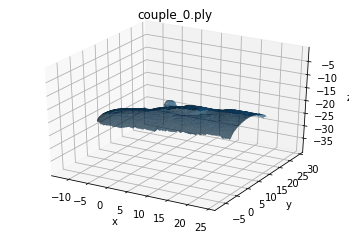

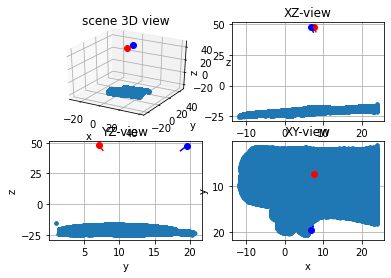

Current folder: ./couple/grab_1_u
Parameters for scan: [0.001, 0.005, array([-12. ,  22. ,   4.5,  17.5, -27. , -10. ]), 4, 2]
Output filename: couple_1.ply
loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



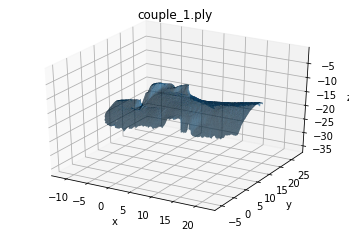

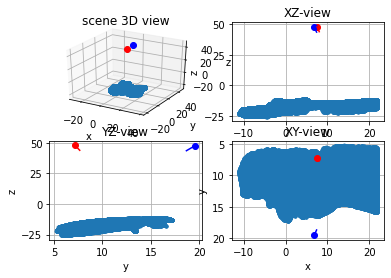

Current folder: ./couple/grab_2_u
Parameters for scan: [0.001, 0.005, array([-15. ,  23. ,   4.5,  22. , -28. , -10. ]), 4, 2]
Output filename: couple_2.ply
loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



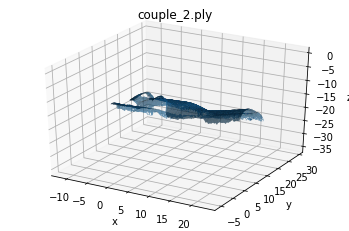

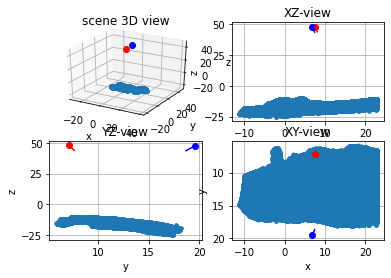

Current folder: ./couple/grab_3_u
Parameters for scan: [0.005, 0.005, array([-12.,  23.,   0.,  20., -25., -12.]), 4, 2]
Output filename: couple_3.ply
loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



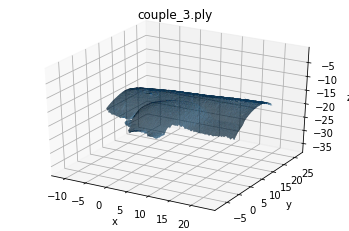

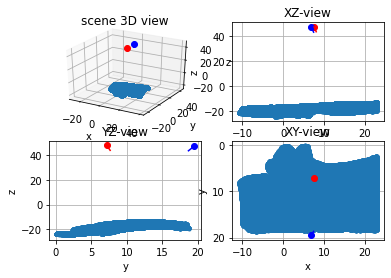

Current folder: ./couple/grab_4_u
Parameters for scan: [0.0025, 0.005, array([ -10.,   23., -100.,  100.,  -22.,  -10.]), 4, 2]
Output filename: couple_4.ply
loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



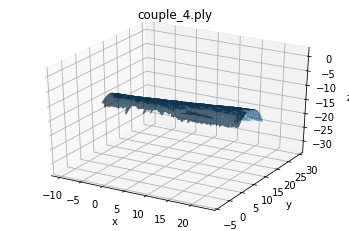

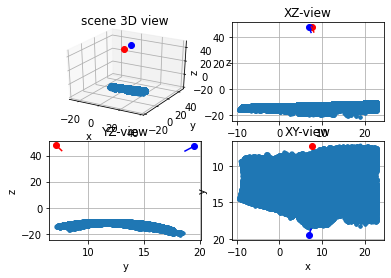

Current folder: ./couple/grab_5_u
Parameters for scan: [0.001, 0.005, array([-12. ,  24.5,   3. ,  20. , -30. , -10. ]), 4, 2]
Output filename: couple_5.ply
loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



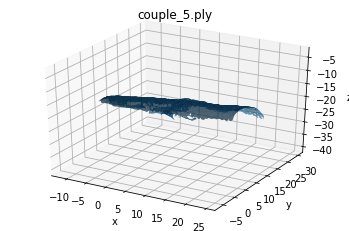

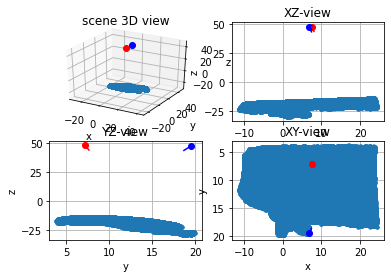

Current folder: ./couple/grab_6_u
Parameters for scan: [0.005, 0.005, array([ 13.5,  21. , -10. ,  22. , -39. ,   2. ]), 4, 2]
Output filename: couple_6.ply
loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



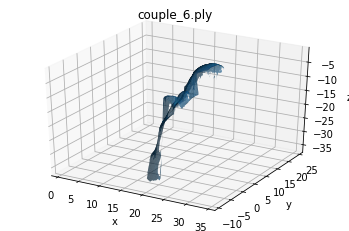

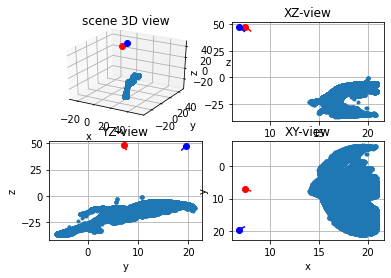

In [6]:
scansFolder = "./couple"
scanCount = len(glob.glob(os.path.join(scansFolder, "*")))

# Parameters for mesh generation
mask_thresholds = [0.005, 0.001, 0.001, 0.005, 0.0025, 0.001, 0.005, 0.005]
decode_thresholds = [0.005] * scanCount
trithresh = 4
smooth_cnt = 2
boxLim = np.array([[-15,24,0.5,22,-27.5,-15],
                 [-12,22,4.5,17.5,-27,-10],
                 [-15,23,4.5,22,-28,-10],
                 [-12,23,0,20,-25,-12],
                 [-10,23,-100,100,-22,-10],
                 [-12,24.5,3,20,-30,-10],
                 [13.5,21,-10,22,-39,2]])

for i in range(scanCount):
    params = [mask_thresholds[i], decode_thresholds[i], boxLim[i], trithresh, smooth_cnt]
    scanfolder = f"{scansFolder}/grab_{i}_u"
    output_fname = f"{scansFolder[2:]}_{i}.ply"
    mesh(scanfolder, camL, camR, params, output_fname)